Loading ONNX generator model...
Processing single image...


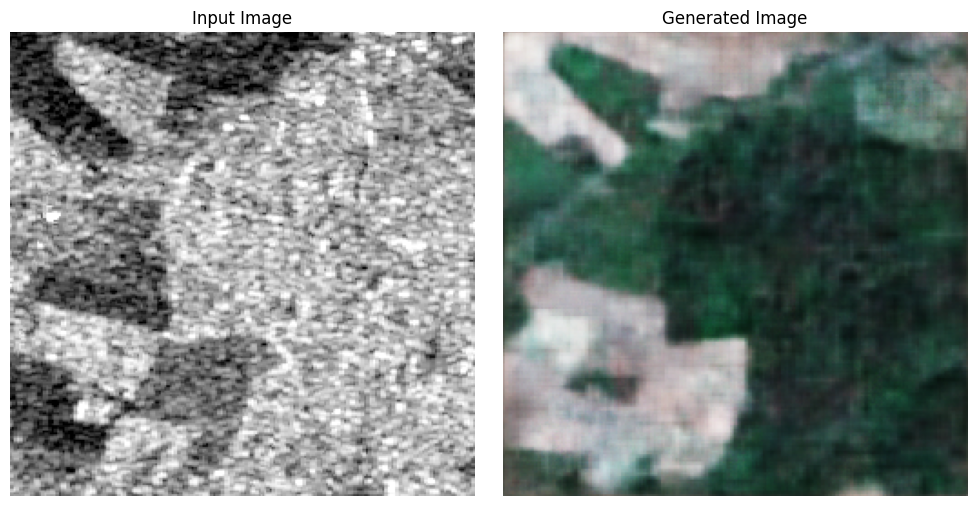

Prediction completed! Result saved to: C:\Users\amanr\Desktop\satellite-colorizer\Output image


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import onnxruntime as ort

def load_generator(model_path):
    """Load a trained generator ONNX model"""
    # Create ONNX Runtime inference session
    session = ort.InferenceSession(model_path)
    return session

def preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess an image for prediction"""
    img = Image.open(image_path).convert('L')  # Ensure grayscale input
    img = img.resize(target_size)
    img_array = np.array(img) / 127.5 - 1.0  # Normalize to [-1,1]
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    return np.expand_dims(img_array, axis=0).astype(np.float32)  # Add batch dimension and ensure float32

def postprocess_image(prediction):
    """Convert model output (-1 to 1) to displayable image (0-255)"""
    img_array = ((prediction[0] + 1) * 127.5).astype(np.uint8)
    return np.clip(img_array, 0, 255)

def predict_and_save(session, input_path, output_path):
    """Make prediction using ONNX model and save result"""
    input_image = preprocess_image(input_path)
    
    # Get input and output names from the ONNX model
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    # Run inference
    prediction = session.run([output_name], {input_name: input_image})[0]
    output_image = postprocess_image(prediction)
    
    # Ensure output_path has a file extension
    if not os.path.splitext(output_path)[1]:
        output_path = output_path + '.png'
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Convert array to image and save
    # Handle RGB (3 channels) or grayscale (1 channel)
    if output_image.shape[-1] == 3:
        Image.fromarray(output_image).save(output_path)
    elif output_image.shape[-1] == 1:
        # Remove the channel dimension for grayscale
        Image.fromarray(output_image.squeeze(-1)).save(output_path)
    else:
        # Handle other channel configurations
        Image.fromarray(output_image.reshape(output_image.shape[0], output_image.shape[1], -1)).save(output_path)
    
    return output_image

def visualize_comparison(input_path, output_path):
    """Display input and output side by side"""
    # Ensure output_path has an extension
    if not os.path.splitext(output_path)[1]:
        output_path = output_path + '.png'
        
    input_img = Image.open(input_path)
    output_img = Image.open(output_path)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(input_img, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Generated Image")
    plt.imshow(output_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example Usage
if __name__ == "__main__":

    MODEL_PATH = r"C:\Users\amanr\Desktop\satellite-colorizer\Colorise\best_model.onnx"
    INPUT_IMAGE = r"C:\Users\amanr\Desktop\agriculture 2.png"
    OUTPUT_IMAGE = r"C:\Users\amanr\Desktop\satellite-colorizer\Output image"
    
    print("Loading ONNX generator model...")
    generator = load_generator(MODEL_PATH)
    
    print("Processing single image...")
    predict_and_save(generator, INPUT_IMAGE, OUTPUT_IMAGE)
    visualize_comparison(INPUT_IMAGE, OUTPUT_IMAGE)
    
    print("Prediction completed! Result saved to:", OUTPUT_IMAGE)